# Chess Performance Stats

**Mounting Google Drive using Code**

In [1]:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 44.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=5294856f27dcc9eacbf6efb96eed5a089603c92aa2691f38e90cd090823a47a9
  Stored in directory: /root/.cache/pip/wheels/83/1f/4e/8f4300f7dd554eb8de70ddfed96e94d3d030ace10c5b53d447
Successfully built chess


**Import Library**

In [9]:
import pandas as pd
import chess.pgn

**Data Wrangling**

In [19]:
games = []
# Replace '/content/drive/My Drive/your_chess_games.pgn' with the actual path to your file
with open("/content/chess.pgn") as pgn:
    while game := chess.pgn.read_game(pgn):
        games.append({
            "date": game.headers["Date"],
            "white": game.headers["White"],
            "black": game.headers["Black"],
            "result": game.headers["Result"],
            "eco": game.headers.get("ECO", ""),  # opening code
            "opening": game.headers.get("Opening", ""),
            "time_control": game.headers.get("TimeControl", ""),
            "WhiteElo": game.headers.get("WhiteElo", ""),
            "BlackElo": game.headers.get("BlackElo", "")
        })

df = pd.DataFrame(games)
print(df.head())

         date           white           black result eco opening time_control  \
0  2025.07.25  Rudra_Pratap18       Hazeminho    0-1                      600   
1  2025.07.25       Hazeminho  Rudra_Pratap18    1-0                      600   
2  2025.07.26  Rudra_Pratap18     naderabdoli    1-0                      600   
3  2025.07.26        Franti48  Rudra_Pratap18    0-1                      600   
4  2025.07.26     aliirezaabd  Rudra_Pratap18    1-0                      600   

  WhiteElo BlackElo  
0     1731     1690  
1     1699     1722  
2     1730     1735  
3     1732     1738  
4     1742     1730  


## **Analysis**

**White vs Black performance**

In [20]:
df["is_white"] = df["white"] == "your_username"
white_wins = df[(df["is_white"]) & (df["result"] == "1-0")].shape[0]
black_wins = df[(~df["is_white"]) & (df["result"] == "0-1")].shape[0]

**Win % by Opening**

In [21]:
opening_stats = df.groupby("opening")["result"].value_counts(normalize=True).unstack().fillna(0)

**Performance vs Opponent Rating**

In [22]:
df["opponent_rating"] = df.apply(
    lambda row: int(row["BlackElo"]) if row["white"]=="Rudra_Pratap18" and row["BlackElo"] else (int(row["WhiteElo"]) if row["black"]=="Rudra_Pratap18" and row["WhiteElo"] else None),
    axis=1
)

**Win Rate by Opening (Bar Chart)**


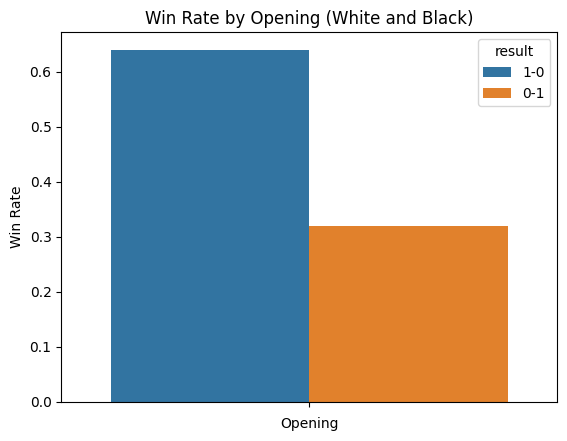

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the opening_stats DataFrame to long format for easier plotting with seaborn
opening_stats_melted = opening_stats.reset_index().melt(id_vars='opening', value_vars=['1-0', '0-1'], var_name='result', value_name='win_rate')

# Filter for wins (1-0 for White, 0-1 for Black)
opening_stats_wins = opening_stats_melted[opening_stats_melted['result'].isin(['1-0', '0-1'])]

sns.barplot(data=opening_stats_wins, x='opening', y='win_rate', hue='result')
plt.xticks(rotation=90)
plt.title("Win Rate by Opening (White and Black)")
plt.ylabel("Win Rate")
plt.xlabel("Opening")
plt.show()

**Rating Progression Over Time (Line Chart)**

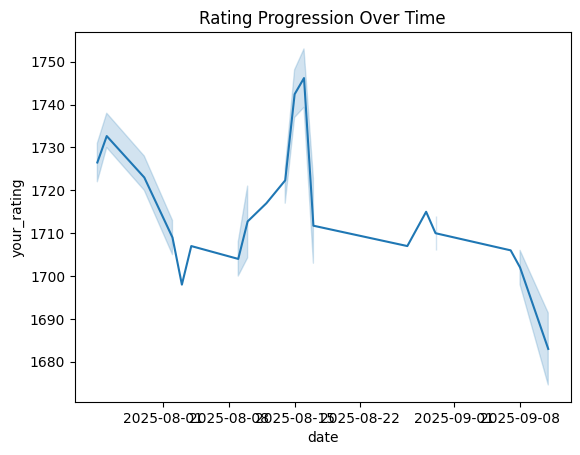

In [26]:
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)

# Create a column for your rating
df["your_rating"] = df.apply(
    lambda row: int(row["WhiteElo"]) if row["white"] == "Rudra_Pratap18" and row["WhiteElo"] else (int(row["BlackElo"]) if row["black"] == "Rudra_Pratap18" and row["BlackElo"] else None),
    axis=1
)
# Drop rows where your_rating is None
df.dropna(subset=["your_rating"], inplace=True)

sns.lineplot(data=df, x="date", y="your_rating")
plt.title("Rating Progression Over Time")
plt.show()

**Heatmap: Results vs Opponent Rating**

/tmp/ipython-input-1624413584.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_bin_results = df.groupby("opponent_rating_bin")["result_numeric"].mean().reset_index()
/tmp/ipython-input-1624413584.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = rating_bin_results.pivot_table(index="opponent_rating_bin", values="result_numeric")


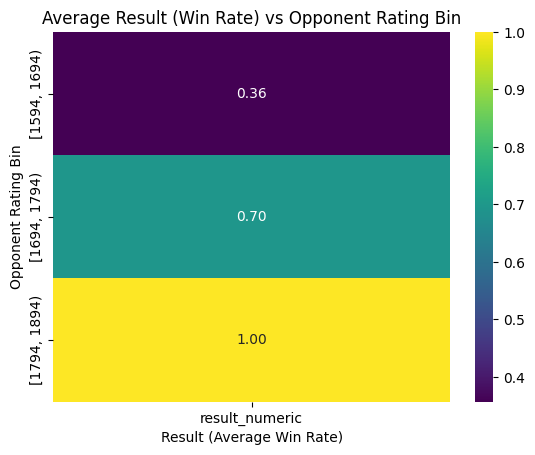

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df["result_numeric"] = df["result"].map({"1-0": 1, "0-1": 0, "1/2-1/2": 0.5})

# Create bins for opponent ratings
# You can adjust the bin edges based on the distribution of ratings in your data
bins = range(df["opponent_rating"].min() - 50, df["opponent_rating"].max() + 100, 100)
df["opponent_rating_bin"] = pd.cut(df["opponent_rating"], bins=bins, right=False)

# Calculate the average result (win rate) for each rating bin
rating_bin_results = df.groupby("opponent_rating_bin")["result_numeric"].mean().reset_index()

# Pivot the data for the heatmap
heatmap_data = rating_bin_results.pivot_table(index="opponent_rating_bin", values="result_numeric")

sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title("Average Result (Win Rate) vs Opponent Rating Bin")
plt.xlabel("Result (Average Win Rate)")
plt.ylabel("Opponent Rating Bin")
plt.show()

**Distribution of Results (Pie Chart)**

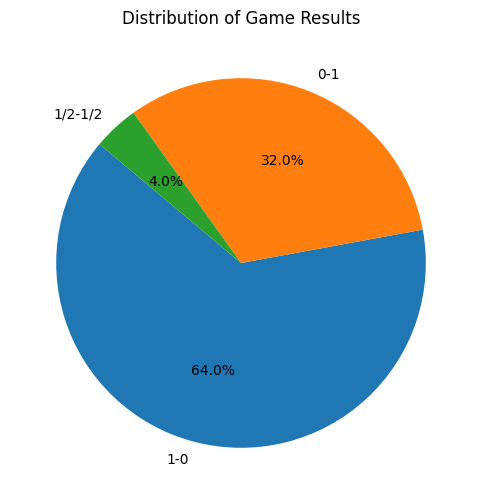

In [31]:
result_counts = df["result"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Game Results")
plt.show()